In [1]:
!pip install scanpy leidenalg scvelo cellrank
!pip install --upgrade matplotlib==3.3.3

  Using cached scvelo-0.2.4-py3-none-any.whl (196 kB)
  Using cached cellrank-1.5.0-py3-none-any.whl (250 kB)
Processing /Users/anna.schaar/Library/Caches/pip/wheels/cb/f8/3f/7072a3f75b1488b4488c41a2b8bcba3d51a0c5c1787a7034cd/loompy-3.0.6-py3-none-any.whl
  Using cached pygpcca-1.0.2-py3-none-any.whl (68 kB)
  Using cached pygam-0.8.0-py2.py3-none-any.whl (1.8 MB)
Processing /Users/anna.schaar/Library/Caches/pip/wheels/5a/73/9d/e6d22f2dacc46a60fb3cb454c64081ec4a691d6e20ccc168dc/numpy_groupies-0.9.14-py3-none-any.whl
  Using cached progressbar2-3.55.0-py2.py3-none-any.whl (26 kB)
  Using cached python_utils-2.5.6-py2.py3-none-any.whl (12 kB)
  Using cached matplotlib-3.3.3-cp38-cp38-macosx_10_9_x86_64.whl (8.5 MB)
ERROR: ncem 0.2.0 has requirement matplotlib<4.0.0,>=3.4.2, but you'll have matplotlib 3.3.3 which is incompatible.
ERROR: csbdeep 0.6.1 has requirement h5py<3, but you'll have h5py 3.1.0 which is incompatible.
ERROR: csbdeep 0.6.1 has requirement keras<2.4,>=2.1.2, but you'll

    Uninstalling matplotlib-3.4.3:
      Successfully uninstalled matplotlib-3.4.3


# Single-cell RNAseq data analysis project

The ability to profile mRNA molecules in a single cell via single-cell RNA-sequencing (scRNA-seq) has revolutionized biology. In the last 7 years that this technology has been available, we have been able to characterize how [organs develop in human fetuses](https://www.science.org/lookup/doi/10.1126/science.aba7721), how whole [organisms develop from a single cell](https://pubmed.ncbi.nlm.nih.gov/29674432/), and we have described how [pancreatic beta cells dedifferentiate in type 2 diabetes](https://www.nature.com/articles/s42255-020-0171-3), amongst many other discoveries. Thus, single-cell profiling methods have been named Nature Methods method of the year already 3 times in this time. In this worksheet we will guide you through a simple scRNA-seq analysis pipeline. Each one of the discoveries above used extensions of the basic principles in this worksheet. 

In this exercise, we will leverage the python package `scanpy`. If you are not familiar with this package, please check out its [documentation](https://scanpy.readthedocs.io/en/stable/).

The tasks will guide you through Quality Control, Normalization, Feature Selection, Clustering, Annotation and Differential Expression Analysis. 


In [1]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In this exercise, we will use a dataset describing the endocrine development in the pancreas from [Bastidas-Ponce et al. (2018)](https://journals.biologists.com/dev/article/146/12/dev173849/19483/Comprehensive-single-cell-mRNA-profiling-reveals-a).

The raw dataset you will need for this dataset can be accessed [here]( https://doi.org/10.6084/m9.figshare.16958587.v1).

In [2]:
adata = sc.read_h5ad('endocrinogenesis_day15.h5ad')

 With scanpy we load an annotated data matrix. This matrix has the following structure. Throught the exercise all analysis results will be stored in the annotated data matrix. If you want to read more about this data format, check [AnnData documentation](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html).

 
 <img src="https://falexwolf.de/img/scanpy/anndata.svg" width="400">

 The main component of an AnnData object is the data matrix `X` of shape `#observations x #variables`, so `number of cells x number of genes`. Gene names and additional information on gene level are stored in `var`. Cell level, e.g. cell type annotation, is stored in `obs`. Unstructured annotations of the dataset of any form are stored in `uns`. 

In [3]:
adata

AnnData object with n_obs × n_vars = 4103 × 27998

The dataset consists of 4,103 cells across 27,998 genes.

## Preprocessing and Quality Control

Next we will look into Preprocessing and Quality Control. 

**Task:** Show the genes that yield the highest fraction of counts in each single cell, across all cells (hint: `sc.pl.highest_expr_genes`). What type of genes do you mainly see? You can look up gene names on genecards.org

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

In [4]:
# annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

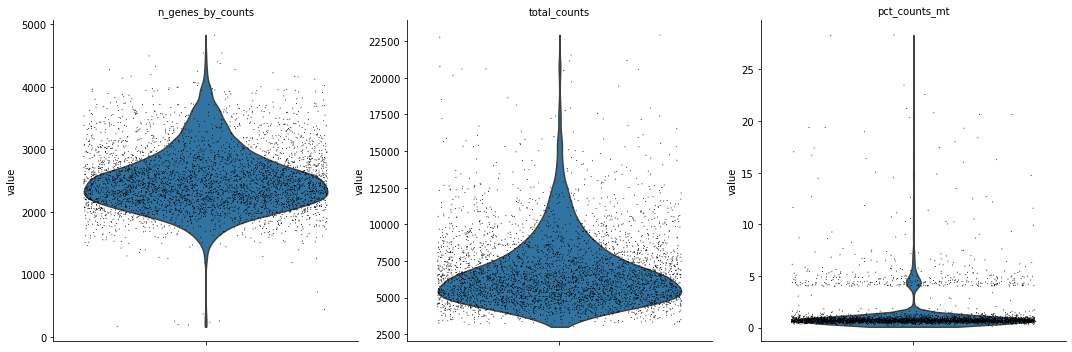

In [5]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

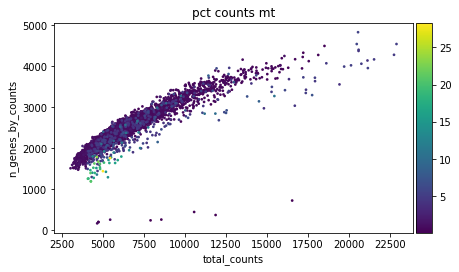

In [6]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt')

**Question:** By looking at the scatter plot, which cells might not meet our quality criteria, and what is happening to them?

**Task:** Plot the distribution of `total_counts` by using `sns.histplot`. Which distribution do you inspect? What cell-level filtering would you apply and why? Support your decision by subplots of the distribution tails. 

**Task:** Filter your dataset (see `sc.pp.filter_cells` and `sc.pp.filter_genes`).

**Question:** Why are we filtering out genes that are not detected?

## Normalization

Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell, so by $x_{gc} = n_{gc} \cdot \xi_{gc}$ with $x_{gc}$ being the normalized expression values, $n_{gc}$ the UM counts and $\xi_{gc}$ the size factor per gene $g$ in cell $c$. 

One basic preprocessing normalization technique assumes that all size factors are equal (library size normalization to **counts per million (CPM)**, so $x_{gc} = n_{gc} \cdot \frac{C}{\sum_g n_{gc}}$ with $C$ a constant at a factor of 10. (see scanpy function `sc.pp.normalize_total`)


After normalization, data matrices are typically $\log(x+1)$‐transformed (see scanpy function `sc.pp.log1p`), which is performed to normalize the data distributions. The offset of 1 ensures that zero counts map to zeros.

**Task:**

Perform CPM normalization on your dataset and subsequently $\log(x+1)$‐transform your data (see `sc.pp.normalize_total` and `sc.pp.log1p`).

**Question:** 

CPM Normalization gives you a relative expression value for each gene within a cell. Some genes scale with cell size, while others don't. How would normalization affect these genes differently?


**Question**: 

Which important effects has $\log(x+1)$ transformation with respect to the distances between expression changes?

## Feature Selection

Here we will use a dispersion-based method to extract HVGs. This method first calculates the mean and a dispersion measure (variance/mean) for each gene in the dataset across all cells. The genes are then places into 20 bins based o their average expression. For each bin, we identify those genes whose expression values are highly varaible compared to the other genes in the same bin by z-normalizing the dispersion measure (see scanpy function `sc.pp.highly_variable_genes`). 

 <img src="https://drive.google.com/uc?export=view&id=1P249LuuviSyiK3ELQzKjUrojD9DNT7iJ" width="500">

**Question** Why do we perform feature selection?

**Task**: Extract the top 2,000 genes of your dataset with a dispersion-based method (see `sc.pp.highly_variable_genes`).

## PCA

Next, we run a Principal Component Analysis (PCA) on the dataset. PCA is used to emphasize variation as well as similarity, and to bring out strong patterns in a dataset. Overall, it also serves as a method for dimensionality reduction.

The figure below shows the concepts of PCA in a nutshell.

 <img src="https://drive.google.com/uc?export=view&id=1POJBu96zemFIRMtp1pMF9wZ3FsG6WzPs" width="800">


**Question:** Why do we do dimensionality reduction?

**Task**: Perform a PCA on the dataset and plot the results (see `sc.tl.pca`).

In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.

**Task**: How many principal components should we consider in order to compute the neighborhood relations of cells (hint: `sc.pl.pca_variance_ratio`) ? How could you leverage this information for downsteam clustering tasks?

## Clustering
Clustering single-cell data makes use of a k-nearest neighbourhood graph representation of the cells (see scanpy function `sc.pp.neighbors`). Typically, we use the `leiden` algorithm which optimizes graph modularity, a cost function that defines how connected groups of nodes in the knn graph are (`sc.tl.leiden`). Modularity, $Q$, is defined as:

$Q = \frac{1}{2m}\sum_{i,j}[A_{ij} - \lambda \frac{k_i k_j}{2m}]\delta(\sigma_i, \sigma_j)$.

Here, $m$ is the number of edges in the graph, $A_{ij}$ is the adjacency matrix of the graph, $k_i = \sum_j A_{ij}$ is the degree of node $i$, $\sigma_i$ indicates the community assignment of node $i$, and $\delta(\sigma_i, \sigma_j)$ is a Kronecker-delta function that is 1 if $\sigma_i = \sigma_j$. $\lambda$ is a variable that is assigned by the user, called the resolution parameter. 

**Question:**
What does a single-cell knn graph represent?

**Question:**
How does the resolution parameter control the clustering resolution?

**Question:** How does the effect of the resolution parameter differ between sparse and dense regions of the single-cell knn graph?

**Task:** Set up a single-cell knn-graph of the pancreas data and cluster these data as you see fit. Present your clustering results as UMAP plots coloured by cluster assignment in the final report.

**Question:** Try a few different clustering resolutions. In some cases you will see that a cluster can be spread out across multiple places on the UMAP plot, with cells from other clusters in between. Why might this be the case? (Hint: you can explore the clustering with different resolution parameters in `sc.tl.leiden`)

## Marker genes
To interpret the clusters, we need to identify the cell types that these clusters represent. This is typically done by finding features (genes) that characterize a cluster from the data, and then comparing these features against other published studies. Someone has usually described the cell type you are looking at before. Here, we are facilitating this process by already giving you a list of cell-type markers that you can use to identify the cells.

Data-driven markers can be detected by statistical tests that assess whether a gene is more highly expressed in one cluster vs the rest. Typically we use simple tests such as a t-test or a Wilcoxon rank sum test here. These tests are implemented in scanpy under `sc.tl.rank_genes_groups`. We can assess whether the gene markers we find are meaningful by comparing their expression across clusters for example in a dotplot (`sc.pl.dotplot`) or by plotting their expression in a UMAP visualization (`sc.tl.umap` and `sc.pl.umap`).

In [ ]:
ct_markers = {
    'Alpha': ['Gcg', 'Arx'],
    'Beta': ['Ins1', 'Ins2',],
    'Delta': ['Sst', 'Hhex'],
    'Epsilon': ['Ghrl'],
    'Ductal': ['Sox9','Anxa2',],
    'Pre-endocrine': ['Neurod1', 'Tox3'],
    'Ngn3 high EP': ['Neurog3', 'Hes6'],
    'Ngn3 low EP': ['Notch2','Cbx3'],
}

In [ ]:
import itertools
all_markers = list(itertools.chain(ct_markers.values()))
flat_markers = list(itertools.chain(*all_markers)) + ['leiden']
sc.pl.umap(adata, color=flat_markers)

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

**Task:** Identify all relevant cell types in the pancreas dataset based on the marker genes given in the dictionary above. Present these results as a UMAP (`sc.tl.umap` and `sc.pl.umap`) coloured by cell type annotation, and a dotplot (`sc.pl.dotplot`) with the markers in the final report. Note, you may have to go back to the subclustering step to improve your clustering.




**Task:** Find additional marker genes for each of the cell types beyond the markers that are provided. Can you find markers that are cell-type specific and some that are present across cell types?

**Task:** Can you find any other cellular substructures in the data that are not described well by only the cell type markers given? Try to cluster these and give marker genes for the clusters.

Note: check out the `restrict_to` parameter in the `sc.tl.leiden` function to perform a subclustering.

**Task:** Remove Alpha cells, and initial state cells from the dataset. And redo the marker gene detection for beta cells. Why do the marker genes for beta cells change?

**Question:** What issues can this change in marker genes cause for defining cell type markers for particular cell types? Discuss how this issue might be avoided.

## Cell type annotation

A prospective annotation based on knowledge from the underlying Biology of each marker gene can be done using the marker genes obtained from this rank_marker_genes, or differential gene expression (see below).

In most cases, this is a semi-iterative process that takes into account verifying known markers, discussion with the Biologist who generated the data regarding known biomarkers used before for certain cell population, and some additional uncertaintity in case labels for some cell types cannot be provided.

**Task**: Use the marker gene plots, the marker gene dictionary, and the clustering results to annotate the cell types you found the data. If you are unsure what to name a cell, add a marker gene to the name to help readers understand. (Hint: check out `adata.rename_categories` to rename your clusters)

**Task:** Check that your clustering and marker genes separate the cells into distinct groups. Check `sc.pl.rank_genes_groups_dotplot` to verify this. Describe the cell states you found and how they are connected.

## DE analysis
Differential expression analysis is a group of statistical tests that are used to establish whether there a exists a significant variation across a set of tested conditions for each gene. In its easiset form, this test can test for the difference between two distinct groups: This scenario can be handled with for example (Welch's) T-test, rank sum tests or Wald and likelihood ratio tests (LRT). Wald tests and LRT allow for more adaptive assumptions on the noise model and can therefore be more statistically correct. Moreover, they also allow the testing of more complex effect, e.g. for the variation across many groups (a single p-value for: Is there any difference between four conditions?) or across continuous covariates (a single covariate for: Is a gene expression trajectory in time non-constant?).

**Task**: Using Scanpy's 'rank_genes_groups' function calculate a t-test and a Wilcoxon rank sum test between Alpha and Beta cells. You can use your own annotation if it fits or the 'cell_type_ann' annotation.

In [ ]:
# Calculate tests here

**Question:** What is the difference in assumptions between these tests?

**Task**: Now plot the top 30 differentially expressed genes for both of the tests. Do they overlap? What are the top 3 differentially expressed genes?


In [ ]:
# Plot the top 30 differentially expressed genes here

**Question:** We calculated the differentially expressed genes using the normalized counts. Should differentially expressed genes be calculated using the unnormalized or the normalized data? Explain your reasoning.

## Trajectory Inference
Trajectory inference approaches analyze genome-wide omics data from thousands of single cells and computationally infer the order of these cells along developmental trajectories.

Many methods for the inference of trajectories exist based on statistical approaches, RNA velocity or optimal transport (see advanced topics below). Here, we introduce [diffusion pseudotime](https://www.nature.com/articles/nmeth.3971), an efficient way of robustly estimating the ordering according to diffusion pseudotime, which measures the transitions between cells using diffusion-like random walks.

Convert UMAP indices to arrays.

In [ ]:
umap_0 = [term[0] for term in adata.obsm['X_umap']]
umap_1 = [term[1] for term in adata.obsm['X_umap']]

Set root cell to the cell with the smallest value in the first UMAP component and compute DPT.

In [ ]:
adata.uns['iroot'] = np.flatnonzero(umap_0== max(umap_0))[0]
sc.tl.dpt(adata = adata)

In [ ]:
sc.pl.umap(adata, color=['dpt_pseudotime'])

**Question**: Why are we selecting the cell with the smallest value in the first UMAP component as the root cell?

**Task**: Plot the diffusion pseudotime and the cell types based on the component combinations 1,2 and 2,3 in a UMAP.

In [ ]:
# Plot here

Single-cell RNA-seq quantifies biological heterogeneity across both discrete cell types and continuous cell transitions. [Partition-based graph abstraction](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1663-x) (PAGA) provides an interpretable graph-like map of the arising data manifold, based on estimating connectivity of manifold partitions. PAGA maps preserve the global topology of data, allow analyzing data at different resolutions, and result in much higher computational efficiency of the typical exploratory data analysis workflow.
In simpler words, PAGA provides an estimation of the connectivity of clusters while maintaining the cluster distribution in space.


**Task**: Calculate and plot a PAGA graph with Scanpy using the 'cell_type' annotation. Which cells are connected? What does the thickness of the arrows mean? What does the result tell you about the biology? Attempt an interpretation.

In [ ]:
# Calculate and plot PAGA here

# Advanced Topics
The advanced topics are not part of the core exercise sheet and are entirely optional. However, they do award bonus points which can offset point losses in the earlier exercises.
By design they do not necessarily introduce all concepts in depth. However, references to core papers and documentation are provided to encourage exploration.

## RNA Velocity 
Here you will learn the basics of [RNA velocity](https://www.nature.com/articles/s41586-018-0414-6) analysis.

RNA abundance is a powerful indicator of the state of individual cells. Single-cell RNA sequencing can reveal RNA abundance with high quantitative accuracy, sensitivity and throughput. However, this approach captures only a static snapshot at a point in time, posing a challenge for the analysis of time-resolved phenomena such as embryogenesis or tissue regeneration. Here we show that RNA velocity—the time derivative of the gene expression state—can be directly estimated by distinguishing between unspliced and spliced mRNAs in common single-cell RNA sequencing protocols. RNA velocity is a high-dimensional vector that predicts the future state of individual cells on a timescale of hours. 

For illustration, it is applied to endocrine development in the pancreas, with lineage commitment to four major fates: α, β, δ and ε-cells. <br/> 
See [here](https://scvelo.readthedocs.io/scvelo.datasets.pancreas.html) for more details.

To analyze the RNA velocity of our Pancreas dataset we will use [scVelo](https://www.nature.com/articles/s41587-020-0591-3).


In [8]:
import scvelo as scv
scv.logging.print_version()

scv.settings.verbosity = 3
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

Running scvelo 0.2.4 (python 3.8.11) on 2021-11-09 11:14.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI's XMLRPC API is currently disabled due to unmanageable load and will be deprecated in the near future. See https://status.python.org/ for more information.


The analysis is based on the in-built [pancreas data](https://scvelo.readthedocs.io/scvelo.datasets.pancreas.html) as used above. Let's get a clean and already annotated copy.

In [9]:
adata = scv.datasets.pancreas()
adata

100%|██████████████████████████████████████| 50.0M/50.0M [00:37<00:00, 1.41MB/s]


AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

The proportion of unsplied and spliced counts is the basis of RNA velocity. Let's have a look:

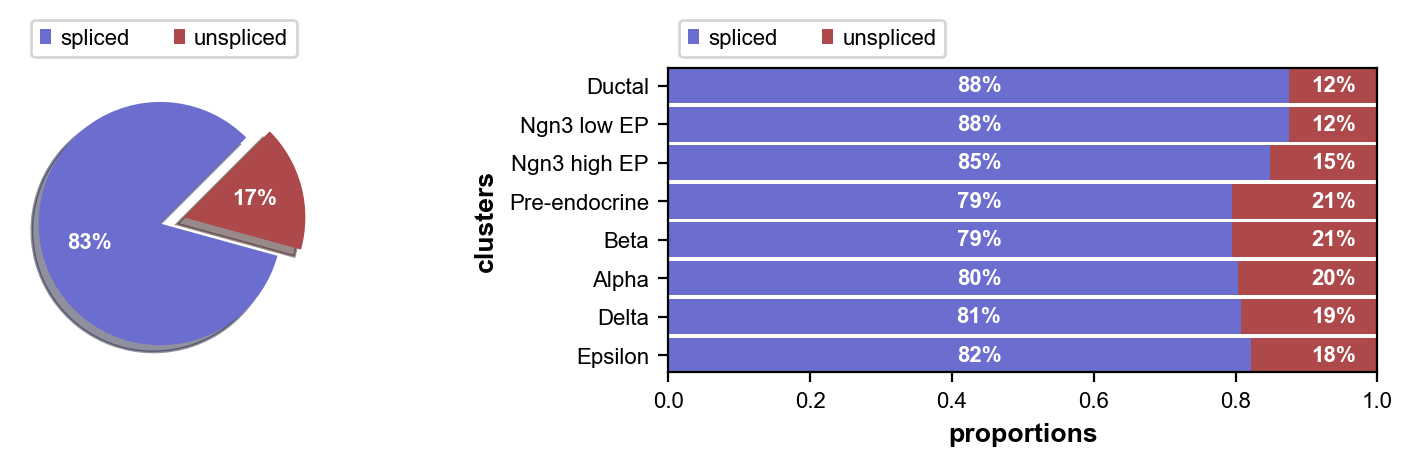

In [10]:
scv.pl.proportions(adata)

Here, the proportions of spliced/unspliced counts are displayed. Depending on the protocol used (Drop-Seq, Smart-Seq), we typically have between 10%-25% of unspliced molecules containing intronic sequences. We also advice the examination of the variations on cluster level to verify consistency in splicing efficiency. Here, we find variations as expected, with slightly lower unspliced proportions at cycling ductal cells, then higher proportion at cell fate commitment in Ngn3-high and Pre-endocrine cells where many genes start to be transcribed.

Preprocessing requisites consist of **gene selection** by detection (with a minimum number of counts) and high variability (dispersion), **normalizing** every cell by its total size and **logarithmizing** X. Filtering and normalization is applied in the same vein to spliced/unspliced counts and X. Logarithmizing is only applied to X. If X is already preprocessed from former analysis, it will not be touched.

All of this is summarized in a single function `scv.pp.filter_and_normalize`, which essentially runs the following:

```
scv.pp.filter_genes(adata, min_shared_counts=20)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=2000)
scv.pp.log1p(adata)
```

Further, we need the first and second order moments (means and uncentered variances) computed among nearest neighbors in PCA space, summarized in `scv.pp.moments`, which internally computes `scv.pp.pca` and `scv.pp.neighbors`.
First order is needed for deterministic velocity estimation, while stochastic estimation also requires second order moments.

In [11]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


Velocities are vectors in gene expression space and represent the direction and speed of movement of the individual cells. The velocities are obtained by modeling transcriptional dynamics of splicing kinetics, either stochastically (default) or deterministically (by setting ``mode='deterministic'``). For each gene, a steady-state-ratio of pre-mature (unspliced) and mature (spliced) mRNA counts is fitted, which constitutes a constant transcriptional state. Velocities are then obtained as residuals from this ratio. Positive velocity indicates that a gene is up-regulated, which occurs for cells that show higher abundance of unspliced mRNA for that gene than expected in steady state. Conversely, negative velocity indicates that a gene is down-regulated.

The solution to the full dynamical model is obtained by setting ``mode='dynamical'``, which requires to run
``scv.tl.recover_dynamics(adata)`` beforehand. We skip the dynamic model in this exercise sheet.

**Task**: Compute the velocities with scVelo.

In [ ]:
# Compute velocities

The computed velocities are stored in ``adata.layers`` just like the count matrices. 

The combination of velocities across genes can then be used to estimate the future state of an individual cell. In order to project the velocities into a lower-dimensional embedding, transition probabilities of cell-to-cell transitions are estimated. That is, for each velocity vector we find the likely cell transitions that are accordance with that direction. The transition probabilities are computed using cosine correlation between the potential cell-to-cell transitions and the velocity vector, and are stored in a matrix denoted as velocity graph. The resulting velocity graph has dimension $n_{obs} \times n_{obs}$ and summarizes the possible cell state changes that are well explained through the velocity vectors (for runtime speedup it can also be computed on reduced PCA space by setting `approx=True`).

**Task**: Compute the velocity graph with scVelo

In [ ]:
# Compute velocity graph

For a variety of applications, the velocity graph can be converted to a transition matrix by applying a Gaussian kernel to transform the cosine correlations into actual transition probabilities. You can access the Markov transition matrix via `scv.utils.get_transition_matrix`. 

As mentioned, it is internally used to project the velocities into a low-dimensional embedding by applying the mean transition with respect to the transition probabilities, obtained with `scv.tl.velocity_embedding`. Further, we can trace cells along the Markov chain to their origins and potential fates, thereby getting root cells and end points within a trajectory, obtained via `scv.tl.terminal_states`.

Finally, the velocities are projected onto any embedding, specified by `basis`, and visualized in one of these ways: 
- on cellular level with `scv.pl.velocity_embedding`,
- as gridlines with `scv.pl.velocity_embedding_grid`,
- or as streamlines with `scv.pl.velocity_embedding_stream`.

Note, that the data has an already pre-computed UMAP embedding, and annotated clusters. When applying to your own data, these can be obtained with `scv.tl.umap` and `scv.tl.louvain`. For more details, see the [scanpy tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html). Further, all plotting functions are defaulted to using `basis='umap'` and `color='clusters'`, which you can set accordingly.

**Task**: Plot the velocity embedding as a stream and examine the result. Which proposed transitions can you see? Is the result biologically sound?

In [ ]:
# Plot velocity embedding as stream

The most fine-grained resolution of the velocity vector field we get at single-cell level, with each arrow showing the direction and speed of movement of an individual cell.

**Task**: Plot the velocity embedding and examine the Ngn3-cells, the α-cells and transient β-cells. What do you see?

In [ ]:
# Plot velocity embedding

This is perhaps the most important part as we advise not to limit biological conclusions to the projected velocities, but to examine individual gene dynamics via phase portraits to understand how inferred directions are supported by particular genes. 

See the gif [here](https://user-images.githubusercontent.com/31883718/80227452-eb822480-864d-11ea-9399-56886c5e2785.gif) to get an idea of how to interpret a spliced vs. unspliced phase portrait. Gene activity is orchestrated by transcriptional regulation. Transcriptional induction for a particular gene results in an increase of (newly transcribed) precursor unspliced mRNAs while, conversely, repression or absence of transcription results in a decrease of unspliced mRNAs. Spliced mRNAs is produced from unspliced mRNA and follows the same trend with a time lag. Time is a hidden/latent variable. Thus, the dynamics needs to be inferred from what is actually measured: spliced and unspliced mRNAs as displayed in the phase portrait. 

Now, let us examine the phase portraits of some marker genes, visualized with <br/> 
`scv.pl.velocity(adata, gene_names)` or `scv.pl.scatter(adata, gene_names)`. 

**Task**: Plot the phase portraits for the genes 'Cpe', 'Gnao1', 'Ins2' and 'Adk' with scVelo.

In [ ]:
# Plot phase portraits

The black line corresponds to the estimated 'steady-state' ratio, i.e. the ratio of unspliced to spliced mRNA abundance which is in a constant transcriptional state. RNA velocity for a particular gene is determined as the residual, i.e. how much an observation deviates from that steady-state line. Positive velocity indicates that a gene is up-regulated, which occurs for cells that show higher abundance of unspliced mRNA for that gene than expected in steady state. Conversely, negative velocity indicates that a gene is down-regulated.

For instance *Cpe* explains the directionality in the up-regulated Ngn3 (yellow) to Pre-endocrine (orange) to β-cells (green), while *Adk*  explains the directionality in the down-regulated Ductal (dark green) to Ngn3 (yellow) to the remaining endocrine cells.

**Task**: Plot a scatterplot of the gene 'Cpe' colored by 'clusters' and 'velocity'. Add an outline for 'Ngn3 high EP, Pre-endocrine, Beta'. What do you see?

In [ ]:
# Plot scatterplot

## Cell Fate Mapping

Fate mapping describes the studying of embryonic origin of adult tissue, cell types and structures. Here, the "fate" of every cell is mapped against the embryo highlighting which part of the embryo will develop into which tissue. This process is also commonly known as cell lineage tracing at the single-cell level where it is also commonly applied to trace tumor development.

One of several tools to determine cell fates is **CellRank**.

This tutorial shows how to work with CellRank using the **low-level mode**. We will interact directly with CellRank's two main modules, [kernels](https://cellrank.readthedocs.io/en/latest/classes.html#kernels) and [estimators](https://cellrank.readthedocs.io/en/latest/classes.html#estimators). For more info on CellRank, see the [documentation](https://cellrank.readthedocs.io/en/latest/) or read the [preprint](https://doi.org/10.1101/2020.10.19.345983). 

The data we use here comes from [Bastidas-Ponce et al. (2018)](https://dev.biologists.org/content/146/12/dev173849.abstract). The AnnData object we download has been preprocessed already and velocities have been computed using scVelo's dynamical model, see the [scVelo tutorial](https://scvelo.readthedocs.io/DynamicalModeling.html) on this for more details. 

In [12]:
import cellrank as cr
scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo')
cr.settings.verbosity = 2

First, we need to get the data. The following commands will download the `adata` object and save it under `datasets/endocrinogenesis_day15.5_preprocessed.h5ad`.

In [13]:
adata = cr.datasets.pancreas_preprocessed()
scv.utils.show_proportions(adata)
adata

100%|████████████████████████████████████████| 140M/140M [01:38<00:00, 1.49MB/s]


Abundance of ['spliced', 'unspliced']: [0.81 0.19]


AnnData object with n_obs × n_vars = 2531 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'dpt_pseudotime'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'diffmap_evals', 'iroot', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_diffmap', 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'fit_t', 

As stated above, this data has been preprocessed already. We can inspect scVelo's computed velocities: 

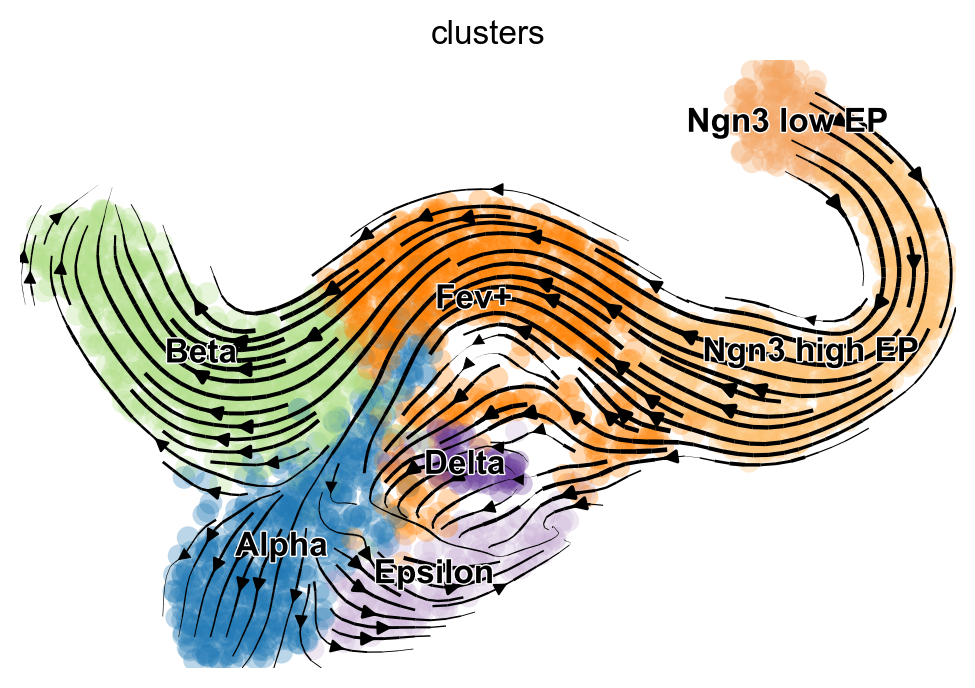

In [14]:
scv.pl.velocity_embedding_stream(adata)

CellRank is a package for analyzing directed single cell data, whereby we mean single cell data that can be respresented via a directed graph. Most prominently, this is the case for single cell data where velocities have been computed - we can use these to direct the KNN graph. However, there are other situations in which we can inform the KNN graph of the direciton of the process, using i.e. pseudotime (see [Palantir](https://doi.org/10.1038/s41587-019-0068-4)) or information obtained via mRNA labeling with e.g. [scSLAM-seq](https://doi.org/10.1038/s41586-019-1369-y), [scEU-seq](https://doi.org/10.1126/science.aax3072) or [sci-fate](https://doi.org/10.1038/s41587-020-0480-9). Because we wanted CellRank to be widely applicable, no matter how directionality was introduced to the data, we split it up into two main modules, `kernels` and `estimators`. In short, `kernels` allow you to compute a (directed) transition matrix, whereas `estimators` allow you to analyze it.

To construct a transition matrix, CellRank offers a number of kernel classes in `cellrank.tl.kernels`. Currently implemented are the following:

 - `VelocityKernel`: compute transition matrix based on RNA velocity.
 - `ConnectivityKernel`: compute symmetric transition matrix based on transcriptomic similarity (essentially a [DPT](https://doi.org/10.1038/nmeth.3971) kernel).
 - `PalantirKernel`: mimics [Palantir](https://doi.org/10.1038/s41587-019-0068-4). Uses pseudotime to direct the KNN graph. 
 
These kernels can be combined by simply using the `+` or `*` operator, we will demonstrate this below. To find out more, check out the [API](https://cellrank.readthedocs.io/en/latest/api.html#kernels). Note that the `kernel` classes are designed to be easy to extend to incoporate future kernels based on e.g. mRNA labeling or other sources of directionality. Let's start with the `VelocityKernel`:

In [15]:
from cellrank.tl.kernels import VelocityKernel
vk = VelocityKernel(adata)

To learn more about this object, we can print it:

In [16]:
print(vk)

<VelocityKernel>


There is not very: much there yet. We can change this by computing the transition matrix. 

**Task:** Compute the transition matrix and examine the velocity kernel again.

There's a lot more info now!
Explain in a couple of words each what the mode, backward and softmax_scale properties describe.

**Task**: Import the connectivity kernel form `cellrank.tl.kernels` and use it to compute a transition matrix. Combine the connectivity kernel with the velocity kernel, giving 80% weight to the velocities and 20% to the connectivities. 

**Task**: Define a variable combined_kernel which combines both kernels, but weights the velocity kernel by 80% and the connectivity kernel by 20%.

In [ ]:
# combined_kernel = None

Estimators take a `kernel` object and offer methods to analyze it. The main objective is to decompose the state space into a set of metastable states (also called macrostates) that represent the slow-time scale dynamics of the process. A subset of these metastable states will be the initial or terminal states of the process, the remaining states will be intermediate transient states. CellRank currently offers two estimator classes in `cellrank.tl.estimators`:

 - `CFLARE`: **C**lustering and **F**iltering **L**eft **A**nd **R**ight **E**igenvectors. Heuristic method based on the spectrum of the transition matrix.
 - `GPCCA`: **G**eneralized **P**erron **C**luster **C**luster **A**nalysis: project the Markov chain onto a small set of macrostates using a Galerkin projection which maximizes the self-transition probability for the macrostates, see [Reuter et al. (2018)](https://doi.org/10.1021/acs.jctc.8b00079). 
 
For more information on the estimators, have a look at the [API](https://cellrank.readthedocs.io/en/latest/api.html#estimators). We will demonstrate the `GPCCA` estimator here, however, the `CFLARE` estimator has a similar set of methods (which do different things internally). Let's start by initializing a `GPCCA` object based on the `combined_kernel` we constructed above, i.e. the one that uses both RNA velocities and connectivities. 

In [ ]:
from cellrank.tl.estimators import GPCCA
# g = GPCCA(combined_kernel)
# print(g)

In addition to the information about the kernel it is based on, this prints out the number of states in the underlying Markov chain. GPCCA needs a real sorted [Schur decomposition](https://en.wikipedia.org/wiki/Schur_decomposition) to work with. 

**Task**: Compute a Schur decomposition of the transition matrix using the `g` object from above and plot the eigenvalues in complex plane. The CellRank documentation will help.

In [ ]:
# Compute schur decomposition

To compute the Schur decomposition, there are two methods implemented

 - `method='brandts'`: use `scipy.linalg.schur` to compute a full real Schur decomposition and sort it using a python implementation of [Brandts (2002)](https://doi.org/10.1002/nla.274). Note that `scipy.linalg.schur` only supports dense matrices, so consider using this for small cell numbers (<10k).
 - `method='krylov'`: use an interative, krylov-subspace based algorightm provided in [SLEPc](https://slepc.upv.es/) to directly compute a partial, sorted, real Schur decomposition. This works with sparse matrices and will scale to extremly large cell numbers. 
 
The real Schur decomposition for transition matrix `T` is given by `Q U Q**(-1)`, where `Q` is orthogonal and `U` is quasi-upper triangular, which means it's upper triangular except for 2x2 blocks on the diagonal. 1x1 blocks on the diagonal represent real eigenvalues, 2x2 blocks on the diagonal represent complex eigenvalues. Above, we plotted the top 20 eigenvalues of the matrix `T` to see whether there is an apparent _eigengap_. In the present case, there seems to be such a gap after the first 3 eigenvalues. We can visualize the corresponding Schur vectors in the embedding: 

In [ ]:
# g.plot_schur(use=3)

These vectors will span an invariant subspace, let's call it `X` (Schur vectors in the columns). The next step in `GPCCA` is to find a linear combination of these vectors such that the Markov chain defined on the subset of states has large selt-transition probability.

**Task**: Compute and plot the macrostates using 3 states. Afterwards plot the individual states. Finally, plot only the most likely cells for each state (discrete).

In [ ]:
# Compute and plot the macrostates here.

Finally, save your results in the AnnData object using the appropriate CellRank function. 

Once we found the terminal states in this dataset, the next big questions is: how likely is each cell to develop towards each of these? In CellRank, we compute this via so-called "absorption probabilities". 

**Task**: Compute absorption probabilities using the `g` object and visualise them in the embedding, so that we have one plot per lineage

In [ ]:
# Calculate absorption probabilites here.

Once we have set the `absorption_probabilities`, we can correlate them against all genes to find potential lineage drivers. Below, we show how to do this for just one state. Note that results are written to the `.var` attribute of `adata`:

In [ ]:
# alpha_drivers = g.compute_lineage_drivers(lineages='Alpha', return_drivers=True)
# alpha_drivers.sort_values(by="Alpha corr", ascending=False)

We can look at some of the identified genes:

In [ ]:
# g.plot_lineage_drivers("Alpha", n_genes=5)

To find genes which may be involved in fate choice early on, we could restrict the correlation to a subset of our clusters using the `cluster_key` and `clusters` parameters. 

**Task**: To bring it all together visualize th efate probabilites towards all terminal states jointly in a single plot with a circular embedding using CellRank.